In [20]:
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import re 
import datetime as dt

# 그래프 Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 예측
# Decision tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
#랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
#그래디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor
# 정규분포 및 회귀분석 등
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
# Support Vector Machine (예측)
from sklearn.svm import SVR
# KNN
from sklearn.neighbors import KNeighborsRegressor

### 분류
#평가함수 (분류)
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#로지스틱 회귀분석
from statsmodels.api import Logit
# Decision tree
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# Support Vector Machine (분류)
from sklearn.svm import SVC
# KNN
from sklearn.neighbors import KNeighborsClassifier
#모델 평가
from sklearn.metrics import f1_score, roc_curve, auc
#주성분 분석
from sklearn.decomposition import PCA


#스케일링
from sklearn.preprocessing import scale, minmax_scale, robust_scale
#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
#선형 회귀모형
from sklearn.linear_model import LinearRegression
#변수선택법 (후진제거법)
from sklearn.feature_selection import RFE
#스케일 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler

In [21]:
df = pd.read_pickle("C:/jupyter_project/빅데이터_미세먼지/FINAL_DATA_0806.pkl")

In [22]:
df = df[df['판매수량']>0]

In [123]:
df['19세비율'] = df['19']/df['인구']

In [124]:
df['19세비율']

0        0.167535
1        0.167535
2        0.167535
3        0.512368
4        0.512368
           ...   
55227    0.111608
55228    0.111608
55229    0.087345
55230    0.087345
55231    0.087345
Name: 19세비율, Length: 53612, dtype: float64

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53612 entries, 0 to 55231
Data columns (total 74 columns):
모름                   53612 non-null object
KF규격                 53612 non-null object
CUSTOMER NAME        53612 non-null object
Calendar Day일 2      53612 non-null object
POS Category Code    53612 non-null object
UPC                  53612 non-null float64
품목명                  53612 non-null object
Sales (Bag)          53612 non-null int64
Sales SU             53612 non-null float64
박스입수                 53612 non-null int64
구분                   53612 non-null object
유통사                  53612 non-null object
SUB-CTG              53612 non-null object
수량(CS)               53612 non-null float64
금액                   53612 non-null int64
가격                   53612 non-null int64
지역                   53612 non-null object
구군                   53612 non-null object
시점                   53612 non-null object
인구                   53612 non-null int64
선행종합지수(2015=100)     53612 non-nu

In [245]:
df.groupby('year')['Sales (Bag)'].agg('sum')

year
2017     993811
2018    1180314
2019     212284
Name: Sales (Bag), dtype: int64

In [126]:
df['먼지합'] = df['PM25'] + df['PM10']

In [127]:
df['KF94판매량'] = df['Sales (Bag)'][df['KF규격'] == 'KF94'] 
df['KF80판매량'] = df['Sales (Bag)'][df['KF규격'] == 'KF80'] 
df['기본마스크판매량'] = df['Sales (Bag)'][df['KF규격'] == '0'] 

In [128]:
df['KF94판매량'] = df['KF94판매량'].fillna(0)
df['KF80판매량'] = df['KF80판매량'].fillna(0)
df['기본마스크판매량'] = df['기본마스크판매량'].fillna(0)

In [129]:
df['Sales (Bag)'].agg('sum')

2386409

In [130]:
df['Sales (Bag)']

0         27
1         28
2         20
3          1
4          2
        ... 
55227    138
55228     73
55229    138
55230     66
55231     27
Name: Sales (Bag), Length: 53612, dtype: int64

In [131]:
df['KF규격'].unique()

array(['0', 'KF94', 'KF80'], dtype=object)

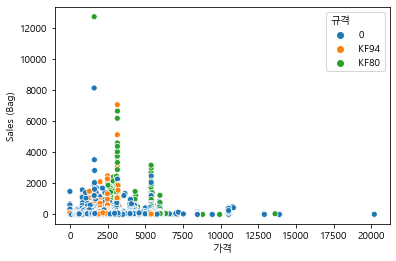

In [132]:
def subtitle_legend(ax, legend_format):
    new_handles = []
    
    handles, labels = ax.get_legend_handles_labels()
    label_dict = dict(zip(labels, handles))
    
    #Means 2 labels were the same
    if len(label_dict) != len(labels):
        raise ValueError("Can not have repeated levels in labels!")
    
    for subtitle, level_order in legend_format.items():
        #Roll a blank handle to add in the subtitle
        blank_handle = mpl.patches.Patch(visible=False, label=subtitle)
        new_handles.append(blank_handle)
        
        for level in level_order:
            handle = label_dict[level]
            new_handles.append(handle)

    #Labels are populated from handle.get_label() when we only supply handles as an arg
    legend = ax.legend(handles=new_handles)

    #Turn off DrawingArea visibility to left justify the text if it contains a subtitle
    for draw_area in legend.findobj(mpl.offsetbox.DrawingArea):
        for handle in draw_area.get_children():
            if handle.get_label() in legend_format:
                draw_area.set_visible(False)

    return legend

ax = sns.scatterplot(x="가격", y="Sales (Bag)",
                    hue="KF규격",
                    data=df)

    #nice and explicit call to reorder the legend
legend_format = {'규격': ['0','KF94', 'KF80']}

subtitle_legend(ax, legend_format=legend_format)

plt.show()

In [133]:
df_char = df.select_dtypes(include = "object")
df_numeric = df.select_dtypes(exclude = "object")

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled, df_char], axis=1)
df_scaled.head()

,UPC,Sales (Bag),Sales SU,박스입수,수량(CS),금액,가격,인구,선행종합지수(2015=100),동행종합지수(2015=100),...,구분,유통사,SUB-CTG,지역,구군,시점,분기,일시,지점,행정구역(시군구)별(3)
0,0.0,-0.112719,0.522279,0.694633,-0.143137,-0.184325,-0.822628,0.311930,-2.225553,-2.192107,...,POS,(주)지에스리테일 본부,MP,경기,평택시,2017-01,2017Q1,2017-01-01,경기,NaN
1,0.0,-0.106283,-0.174198,0.694633,-0.131885,-0.112896,-0.102055,0.311930,-2.225553,-2.192107,...,POS,(주)지에스리테일 본부,MG,경기,평택시,2017-01,2017Q1,2017-01-01,경기,NaN
2,0.0,-0.157775,-0.174198,0.694633,-0.154389,-0.167998,-0.193266,0.311930,-2.225553,-2.192107,...,POS,(주)지에스리테일 본부,MG,경기,평택시,2017-01,2017Q1,2017-01-01,경기,NaN
3,0.0,-0.280068,-0.148402,0.694633,-0.199396,-0.279018,-0.345286,-1.669959,-2.225553,-2.192107,...,POS,(주)지에스리테일 본부,MG,경기,포천시,2017-01,2017Q1,2017-01-01,경기,NaN
4,0.0,-0.273631,-0.122607,0.694633,-0.199396,-0.274120,-0.406094,-1.669959,-2.225553,-2.192107,...,POS,(주)지에스리테일 본부,MP,경기,포천시,2017-01,2017Q1,2017-01-01,경기,NaN


In [134]:
df_gu_sum = df.groupby(['지역','구군','시점']).agg('mean')
df_gu_sum['판매수량'] = df.groupby(['지역','구군','시점'])['판매수량'].agg('sum')
df_gu_sum['금액'] = df.groupby(['지역','구군','시점'])['금액'].agg('sum')
df_gu_sum = df_gu_sum.reset_index()

In [135]:
df_do_sum = df.groupby(['지역','시점']).agg('mean')
df_do_sum['판매수량'] = df.groupby(['지역','시점'])['판매수량'].agg('sum')
df_do_sum['금액'] = df.groupby(['지역','시점'])['금액'].agg('sum')
df_do_sum = df_do_sum.reset_index()

In [136]:
df_total = df.groupby(['시점']).agg('mean')
df_total['판매수량'] = df.groupby(['시점'])['판매수량'].agg('sum')
df_total['금액'] = df.groupby(['시점'])['금액'].agg('sum')
df_total = df_total.reset_index()

In [137]:
df_total_KF = df.groupby(['시점','KF규격']).agg('mean')
df_total_KF['판매수량'] = df.groupby(['시점', 'KF규격'])['판매수량'].agg('sum')
df_total_KF['금액'] = df.groupby(['시점','KF규격'])['금액'].agg('sum')
df_total_KF = df_total_KF.reset_index()

In [138]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 59 columns):
시점                  27 non-null object
UPC                 27 non-null float64
Sales (Bag)         27 non-null float64
Sales SU            27 non-null float64
박스입수                27 non-null float64
수량(CS)              27 non-null float64
금액                  27 non-null int64
가격                  27 non-null float64
인구                  27 non-null float64
선행종합지수(2015=100)    27 non-null float64
동행종합지수(2015=100)    27 non-null float64
후행종합지수(2015=100)    27 non-null float64
gdp                 27 non-null float64
연령                  27 non-null float64
평균소득                27 non-null float64
SO2                 27 non-null float64
CO                  27 non-null float64
O3                  27 non-null float64
NO2                 27 non-null float64
PM10                27 non-null float64
PM25                27 non-null float64
month               27 non-null float64
day                 

# 초미세먼지 검색량 / 초미세먼지 양 비례 안함

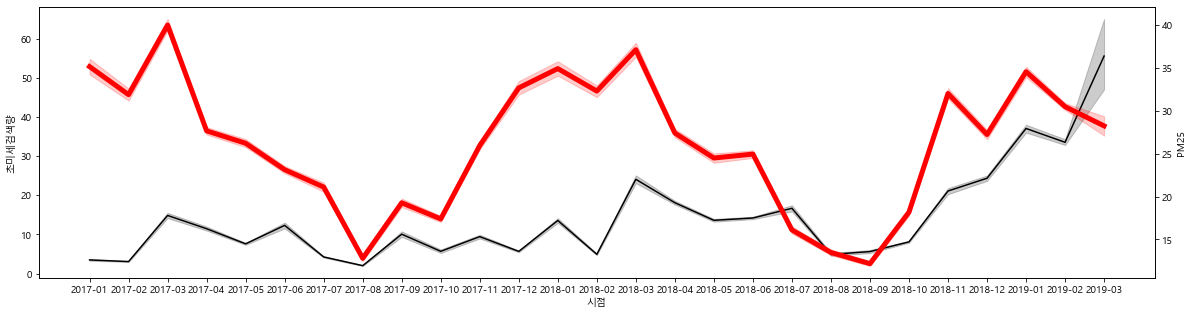

In [139]:
plt.figure(figsize = [20,5])
x_var = '시점'
y_var1 = '초미세검색량'
y_var2 = 'PM25'

sns.lineplot(data=df, x=x_var,y=y_var1, markers=True, color = "black")
ax1 = plt.twinx()
sns.lineplot(data=df, x=x_var,y=y_var2, ax=ax1, markers=True, color = "r",linewidth=5)

# 미세먼지 검색량 / 미세먼지 양 비례 안함

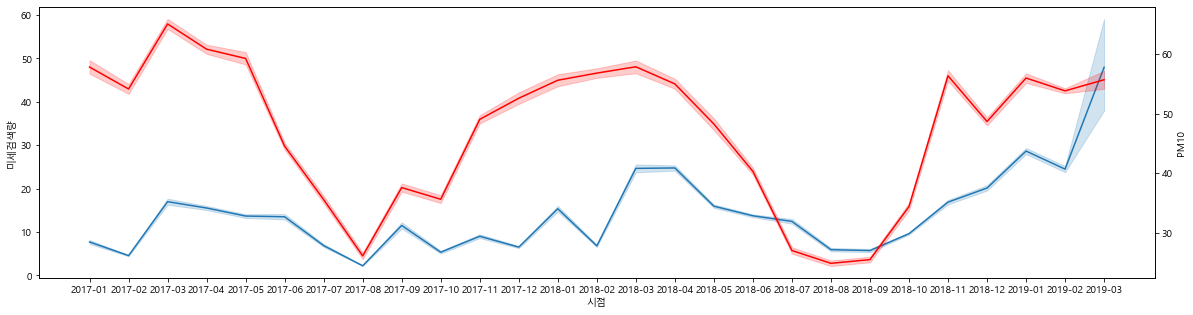

In [140]:
plt.figure(figsize = [20,5])
x_var = '시점'
y_var1 = '미세검색량'
y_var2 = 'PM10'

sns.lineplot(data=df, x=x_var,y=y_var1, markers=True)
ax1 = plt.twinx()
sns.lineplot(data=df, x=x_var,y=y_var2, ax=ax1, markers=True, color = "r")

# 마스크 판매량 / 초미세먼지 양 비례 안함

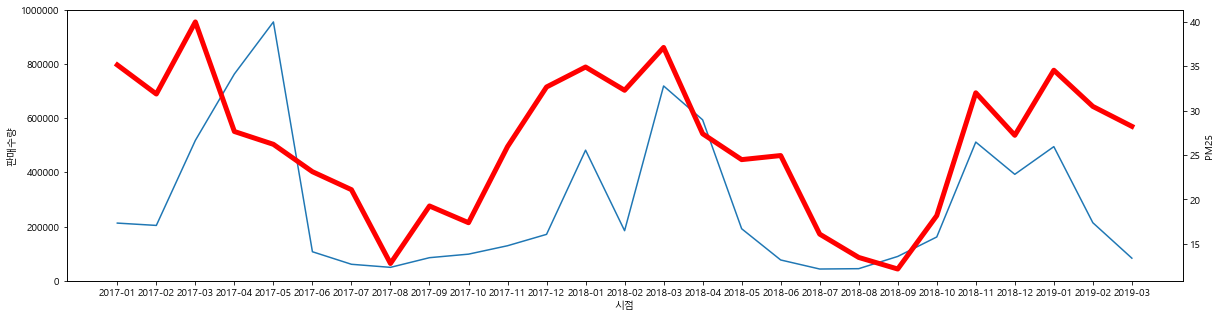

In [141]:
plt.figure(figsize = [20,5])
x_var = '시점'
y_var1 = '판매수량'
y_var2 = 'PM25'

sns.lineplot(data=df_total, x=x_var,y=y_var1, markers=True)
ax1 = plt.twinx()
sns.lineplot(data=df_total, x=x_var,y=y_var2, ax=ax1, markers=True, color = "r",linewidth=5)

# 마스크 판매량(일평균치) / 미세먼지 검색량 비례함

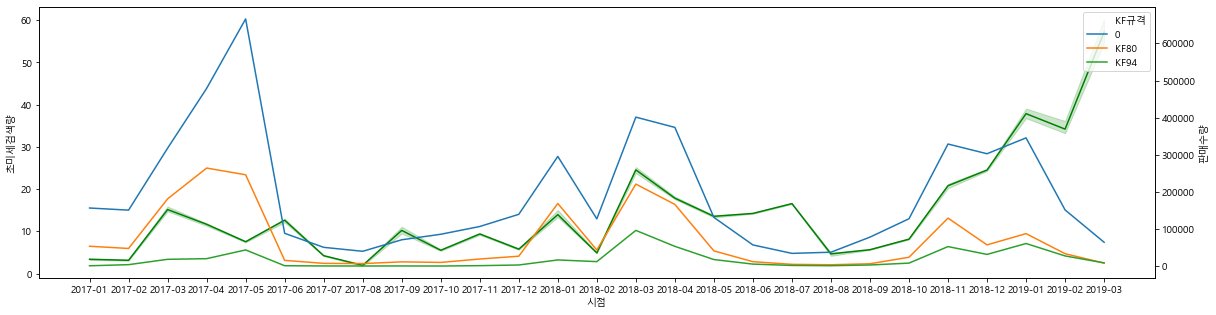

In [142]:
plt.figure(figsize = [20,5])
x_var = '시점'
y_var1 = '초미세검색량'
y_var2 = '판매수량'

sns.lineplot(data=df_total_KF, x=x_var,y=y_var1, markers=True, color = "g")
ax1 = plt.twinx()
sns.lineplot(data=df_total_KF, x=x_var,y=y_var2, ax=ax1, hue='KF규격', markers=True)

# KF규격 마스크 판매량 / 미세먼지 검색량 완전히 비례함

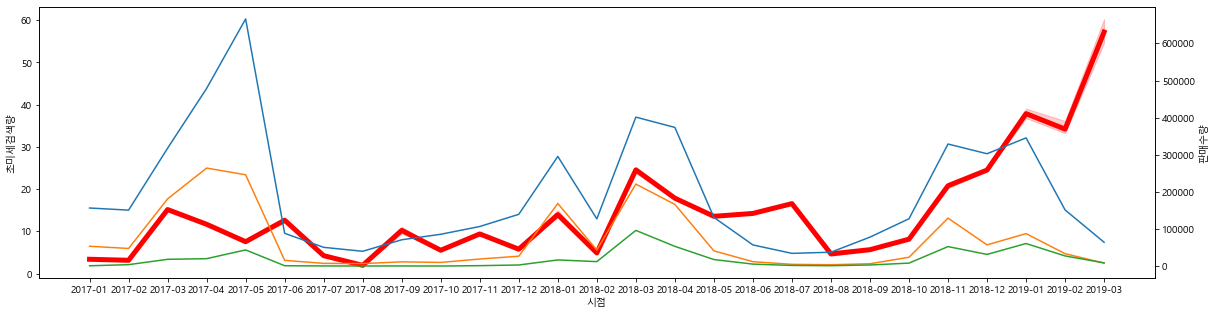

In [143]:
plt.figure(figsize = [20,5])
x_var = '시점'
y_var1 = '초미세검색량'
y_var2 = '판매수량'

sns.lineplot(data=df_total_KF, x=x_var,y=y_var1, markers=True, color = "r",linewidth=5)
ax1 = plt.twinx()
sns.lineplot(data=df_total_KF, x=x_var,y=y_var2, ax=ax1, hue='KF규격', markers=True, legend=False)

# 미세먼지 양과 판매량은 비례하지 않고, 미세먼지양 많은 이후 점점 높게 나타남

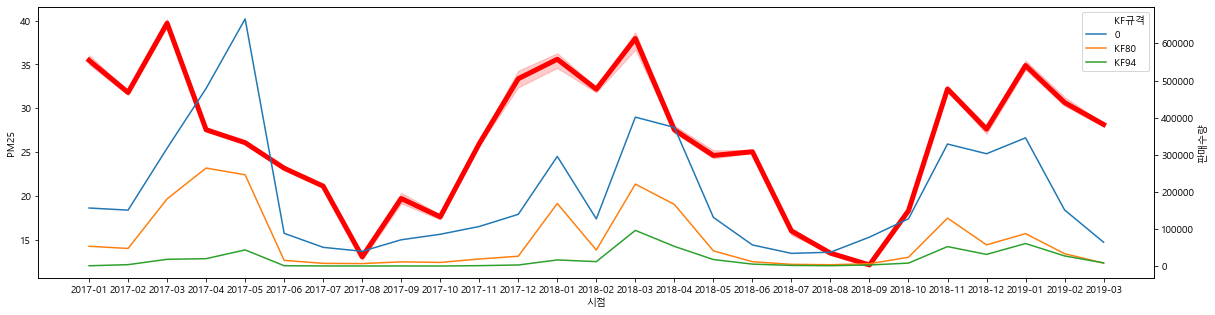

In [144]:
plt.figure(figsize = [20,5])
x_var = '시점'
y_var1 = 'PM25'
y_var2 = '판매수량'

sns.lineplot(data=df_total_KF, x=x_var,y=y_var1, markers=True, color="r",linewidth=5)
ax1 = plt.twinx()
sns.lineplot(data=df_total_KF, x=x_var,y=y_var2, ax=ax1, hue='KF규격', markers=True)

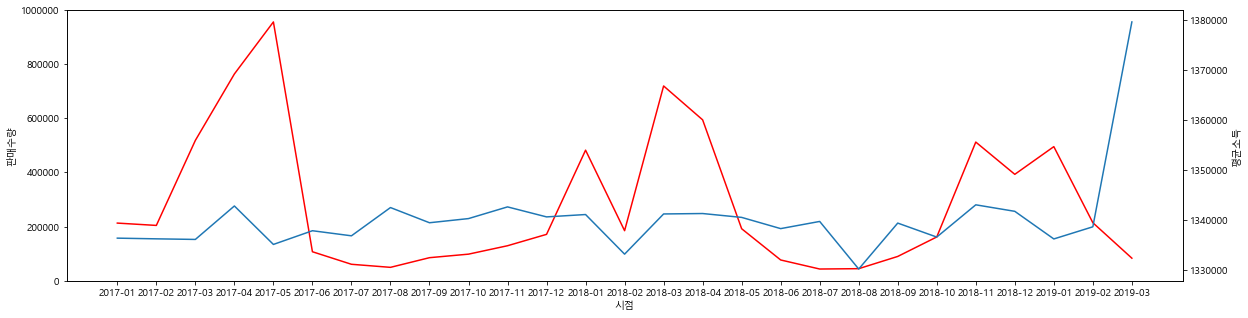

In [145]:
plt.figure(figsize = [20,5])
x_var = '시점'
y_var1 = '판매수량'
y_var2 = '평균소득'

sns.lineplot(data=df_total, x=x_var,y=y_var1, markers=True, color="r")
ax1 = plt.twinx()
sns.lineplot(data=df_total, x=x_var,y=y_var2, ax=ax1, markers=True)

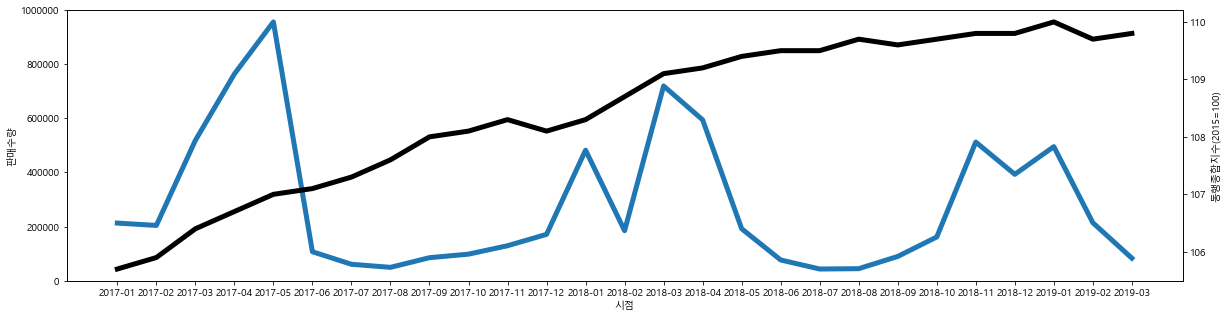

In [146]:
plt.figure(figsize = [20,5])
x_var = '시점'
y_var1 = '판매수량'
y_var2 = '동행종합지수(2015=100)'

sns.lineplot(data=df_total, x=x_var,y=y_var1, markers=True,linewidth=5)
ax1 = plt.twinx()
sns.lineplot(data=df_total, x=x_var,y=y_var2, ax=ax1, markers=True, color="black",linewidth=5)

# 인구수와 판매량간의 관계

In [147]:
df_do_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 60 columns):
지역                  81 non-null object
시점                  81 non-null object
UPC                 81 non-null float64
Sales (Bag)         81 non-null float64
Sales SU            81 non-null float64
박스입수                81 non-null float64
수량(CS)              81 non-null float64
금액                  81 non-null int64
가격                  81 non-null float64
인구                  81 non-null float64
선행종합지수(2015=100)    81 non-null float64
동행종합지수(2015=100)    81 non-null float64
후행종합지수(2015=100)    81 non-null float64
gdp                 81 non-null float64
연령                  81 non-null float64
평균소득                81 non-null float64
SO2                 81 non-null float64
CO                  81 non-null float64
O3                  81 non-null float64
NO2                 81 non-null float64
PM10                81 non-null float64
PM25                81 non-null float64
month               8

In [148]:
df_gu_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968 entries, 0 to 1967
Data columns (total 61 columns):
지역                  1968 non-null object
구군                  1968 non-null object
시점                  1968 non-null object
UPC                 1968 non-null float64
Sales (Bag)         1968 non-null float64
Sales SU            1968 non-null float64
박스입수                1968 non-null float64
수량(CS)              1968 non-null float64
금액                  1968 non-null int64
가격                  1968 non-null float64
인구                  1968 non-null float64
선행종합지수(2015=100)    1968 non-null float64
동행종합지수(2015=100)    1968 non-null float64
후행종합지수(2015=100)    1968 non-null float64
gdp                 1968 non-null float64
연령                  1968 non-null float64
평균소득                1968 non-null float64
SO2                 1968 non-null float64
CO                  1968 non-null float64
O3                  1968 non-null float64
NO2                 1968 non-null float64
PM10            

In [149]:
df_gu_sum_seo = df_gu_sum[df_gu_sum['지역'] == '서울']

In [150]:
df_gu_sum_seo_jung = df_gu_sum[df_gu_sum['구군'] == '중구']

In [227]:
df_gu_sum_not = df.groupby(['지역','구군']).agg('mean')
df_gu_sum_not['판매수량'] = df.groupby(['지역','구군'])['판매수량'].agg('sum')
df_gu_sum_not['금액'] = df.groupby(['지역','구군'])['금액'].agg('sum')
df_gu_sum_not = df_gu_sum_not.reset_index()

In [228]:
df_gu_sum_not['지역구'] = df_gu_sum_not['지역'] + " " +  df_gu_sum_not['구군']

In [229]:
df_gu_sum_sorted = df_gu_sum_not.sort_values(by=['판매수량'], ascending=[False])

In [230]:
df_gu_sum_sorted = df_gu_sum_sorted.reset_index(inplace = False)

In [231]:
df_gu_sum_sorted.shape

(77, 62)

In [232]:
df_gu_sum_sorted = df_gu_sum_sorted.loc[0:20]

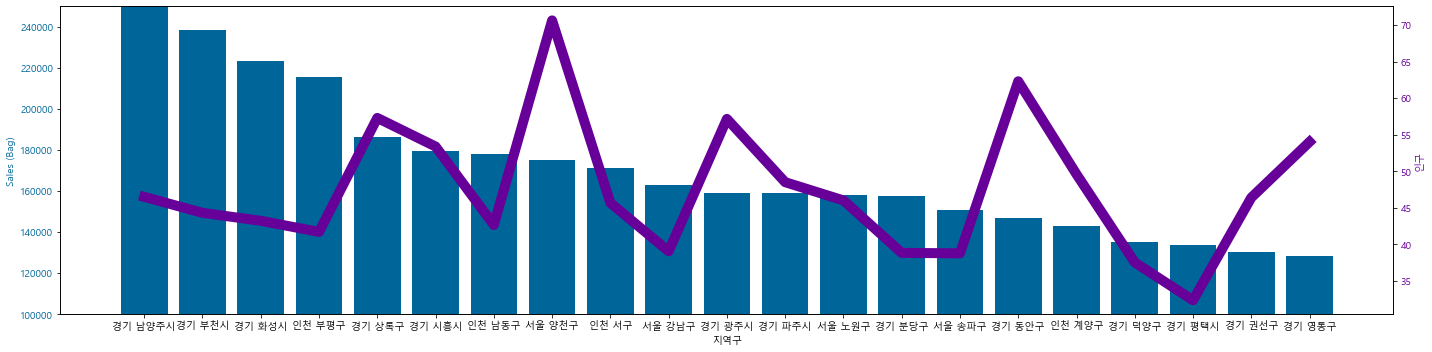

In [233]:
x_var_lab = '지역구'
x_var = df_gu_sum_sorted['지역구']
y_var1 = 'Sales (Bag)'
y_var2 = '인구'

fig, ax1 = plt.subplots(figsize = [20,5])

color = '#006699'
ax1.set_xlabel(x_var_lab)
ax1.set_ylabel(y_var1, color=color)
ax1.bar(x_var, df_gu_sum_sorted['판매수량'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim((100000, 250000))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#660099'
ax2.set_ylabel(y_var2, color=color)  # we already handled the x-label with ax1
ax2.plot(x_var,df_gu_sum_sorted['Sales (Bag)'], color=color,linewidth=10)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

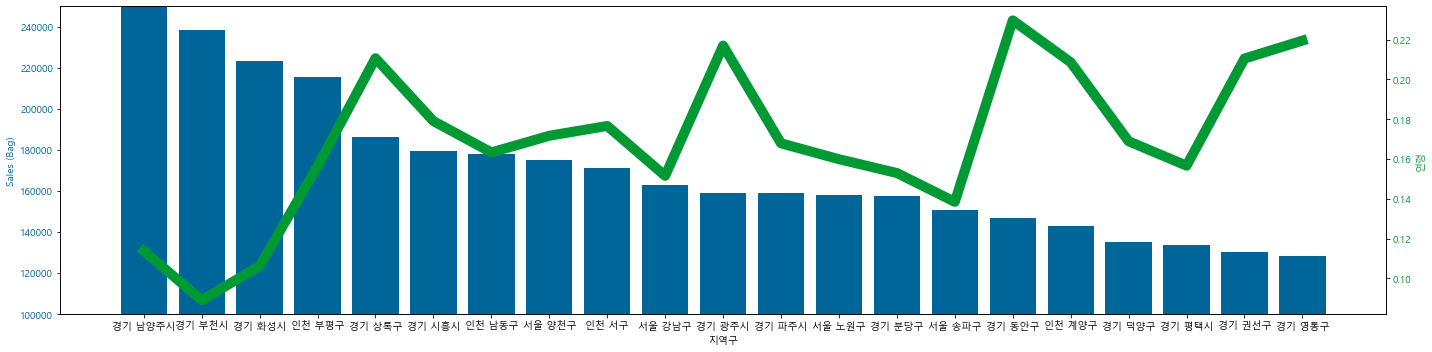

In [236]:
x_var_lab = '지역구'
x_var = df_gu_sum_sorted['지역구']
y_var1 = 'Sales (Bag)'
y_var2 = '연령'

fig, ax1 = plt.subplots(figsize = [20,5])

color = '#006699'
ax1.set_xlabel(x_var_lab)
ax1.set_ylabel(y_var1, color=color)
ax1.bar(x_var, df_gu_sum_sorted['판매수량'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim((100000, 250000))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#009933'
ax2.set_ylabel(y_var2, color=color)  # we already handled the x-label with ax1
ax2.plot(x_var,df_gu_sum_sorted['19세비율'], color=color,linewidth=10)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [159]:
df['19'].head()

0    79099.935484
1    79099.935484
2    79099.935484
3    79099.935484
4    79099.935484
Name: 19, dtype: float64

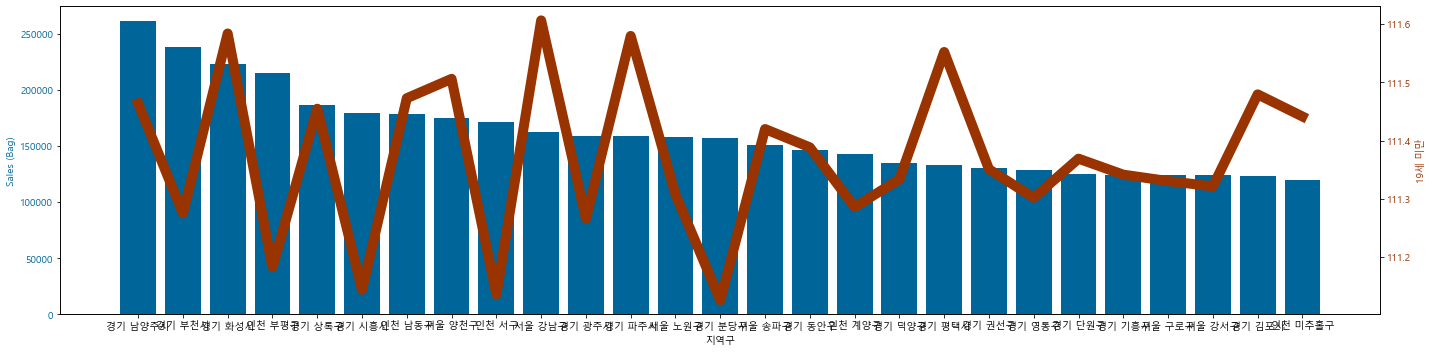

In [160]:
x_var_lab = '지역구'
x_var = df_gu_sum_sorted['지역구']
y_var1 = 'Sales (Bag)'
y_var2 = '19세 미만'

fig, ax1 = plt.subplots(figsize = [20,5])

color = '#006699'
ax1.set_xlabel(x_var_lab)
ax1.set_ylabel(y_var1, color=color)
ax1.bar(x_var, df_gu_sum_sorted['판매수량'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#993300'
ax2.set_ylabel(y_var2, color=color)  # we already handled the x-label with ax1
ax2.plot(x_var,df_gu_sum_sorted['선행종합지수(2015=100)'], color=color,linewidth=10)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

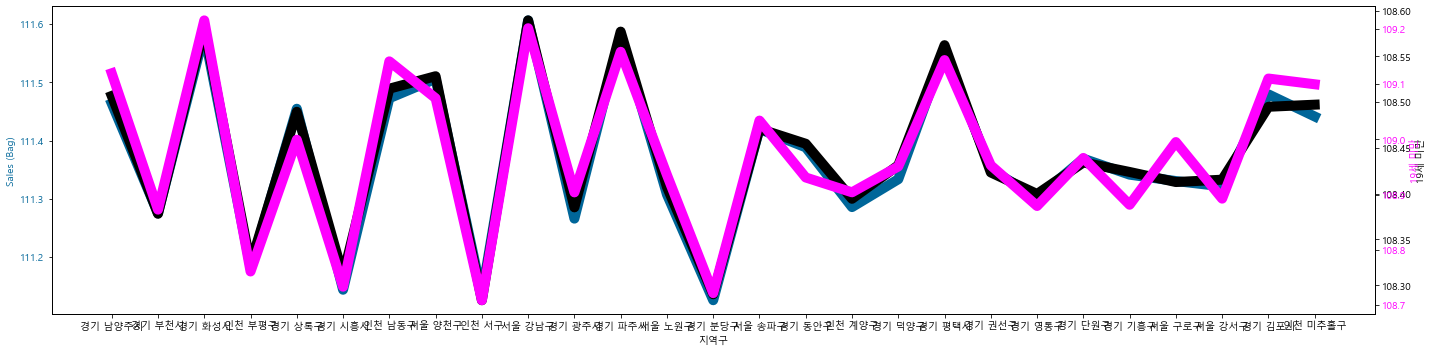

In [116]:
x_var_lab = '지역구'
x_var = df_gu_sum_sorted['지역구']
y_var1 = 'Sales (Bag)'
y_var2 = '19세 미만'

fig, ax1 = plt.subplots(figsize = [20,5])

color = '#006699'
ax1.set_xlabel(x_var_lab)
ax1.set_ylabel(y_var1, color=color)
ax1.plot(x_var, df_gu_sum_sorted['선행종합지수(2015=100)'], color=color,linewidth=10)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#000000'
ax2.set_ylabel(y_var2, color=color)  # we already handled the x-label with ax1
ax2.plot(x_var,df_gu_sum_sorted['동행종합지수(2015=100)'], color=color,linewidth=10)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#FF00FF'
ax3.set_ylabel(y_var2, color=color)  # we already handled the x-label with ax1
ax3.plot(x_var,df_gu_sum_sorted['후행종합지수(2015=100)'], color=color,linewidth=10)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [72]:
df_corr = df_gu_sum_sorted.corr()

In [73]:
df_corr.to_csv("C:/jupyter_project/빅데이터_미세먼지/상관_0805.csv", encoding='CP949')

ValueError: Could not interpret input '지역구'

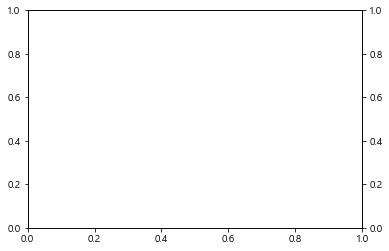

In [244]:
ax1 = plt.twinx()
sns.lineplot(data=df_do_sum, x=x_var,y=y_var2, ax=ax1, hue="지역", markers=True)

In [20]:
df_char = df_total.select_dtypes(include = "object")
df_numeric = df_total.select_dtypes(exclude = "object")

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

df_sca_ttl = pd.concat([df_numeric_scaled, df_char], axis=1)
df_sca_ttl.head()

,UPC,Sales (Bag),Sales SU,박스입수,수량(CS),금액,가격,인구,선행종합지수(2015=100),동행종합지수(2015=100),...,최저운고(100m ),시정(10m),지면온도(°C),미세검색량,초미세검색량,먼지합,KF94판매량,KF80판매량,기본마스크판매량,시점
0,0.0,-0.525482,-0.138071,0.222573,-0.355462,-0.429930,0.988882,-0.179964,-2.137974,-2.106576,...,-0.657540,-0.065402,-1.198011,-0.635903,-0.858979,0.783808,-0.483873,-0.205903,-0.372666,2017-01
1,0.0,-0.495365,-0.069752,-0.508577,-0.343988,-0.451881,0.656134,-0.299743,-1.905023,-1.953061,...,-0.409694,0.722396,-1.108003,-0.943795,-0.885490,0.420686,-0.456703,-0.237432,-0.341759,2017-02
2,0.0,0.555943,0.415052,-0.899661,0.668971,0.510575,0.686516,0.486898,-1.765253,-1.569271,...,0.146784,-0.156357,-0.485944,0.173969,-0.006856,1.740508,0.008646,1.731668,0.361739,2017-03
3,0.0,1.430800,2.027513,-0.448360,0.936578,1.383996,0.229398,0.314000,-1.532301,-1.338998,...,0.309381,0.443602,0.204823,0.101777,-0.236338,0.616095,-0.072925,2.143772,0.920605,2017-04
4,0.0,2.573591,4.383171,0.904294,1.042770,2.488695,-0.197958,-0.582232,-1.252760,-1.108724,...,-0.208298,0.572284,0.911638,0.043716,-0.474929,1.173945,0.355281,1.487010,2.079748,2017-05


# 대기유해물질과 미세먼지 농도간의 관계

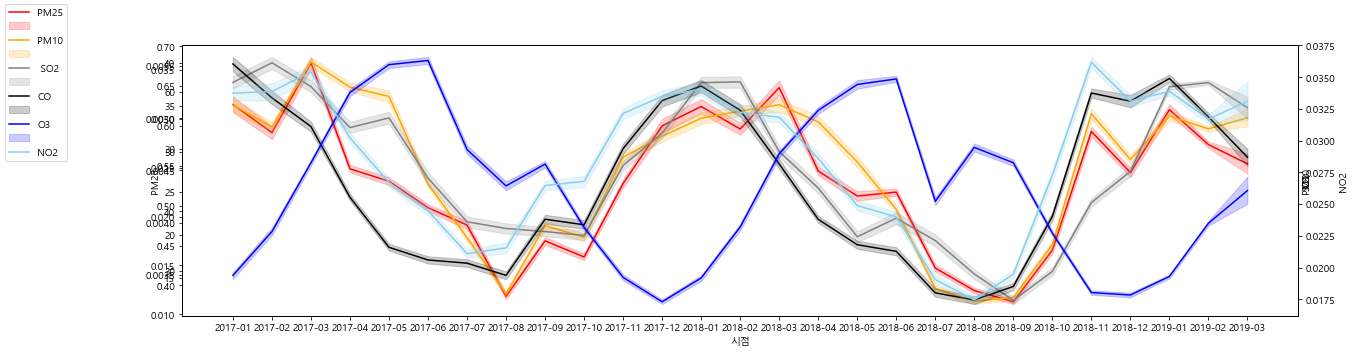

In [184]:
fig = plt.figure(figsize=(20,5))

sns.lineplot(data=df, x='시점',y='PM25', color="red")

ax1 = plt.twinx()
sns.lineplot(data=df, x='시점',y='PM10', ax=ax1, color="orange")

ax2 = plt.twinx()
sns.lineplot(data=df, x='시점',y='SO2', ax=ax2, color="gray")

ax3 = plt.twinx()
sns.lineplot(data=df, x='시점',y='CO', ax=ax3, color="black")

ax4 = plt.twinx()
sns.lineplot(data=df, x='시점',y='O3', ax=ax4, color="blue")

ax5 = plt.twinx()
sns.lineplot(data=df, x='시점',y='NO2', ax=ax5, color="skyblue")

fig.legend(labels=['PM25','', 'PM10','', ' SO2','', 'CO','', 'O3','', 'NO2'], ncol=1, loc='upper left')

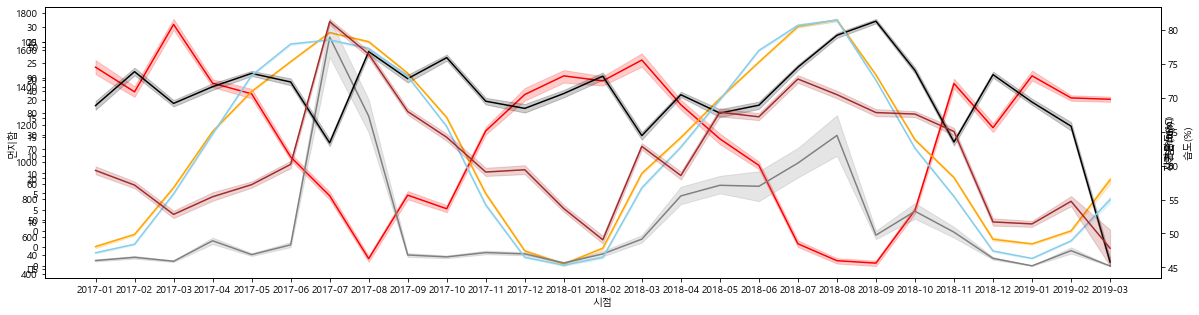

In [185]:
fig = plt.figure(figsize=(20,5))

sns.lineplot(data=df, x='시점',y='먼지합', color="red")

ax1 = plt.twinx()
sns.lineplot(data=df, x='시점',y='기온(°C)', ax=ax1, color="orange")

ax2 = plt.twinx()
sns.lineplot(data=df, x='시점',y='강수량(mm)', ax=ax2, color="gray")

ax3 = plt.twinx()
sns.lineplot(data=df, x='시점',y='시정(10m)', ax=ax3, color="black")

ax5 = plt.twinx()
sns.lineplot(data=df, x='시점',y='지면온도(°C)', ax=ax5, color="skyblue")

ax6 = plt.twinx()
sns.lineplot(data=df, x='시점',y='습도(%)', ax=ax6, color="brown")


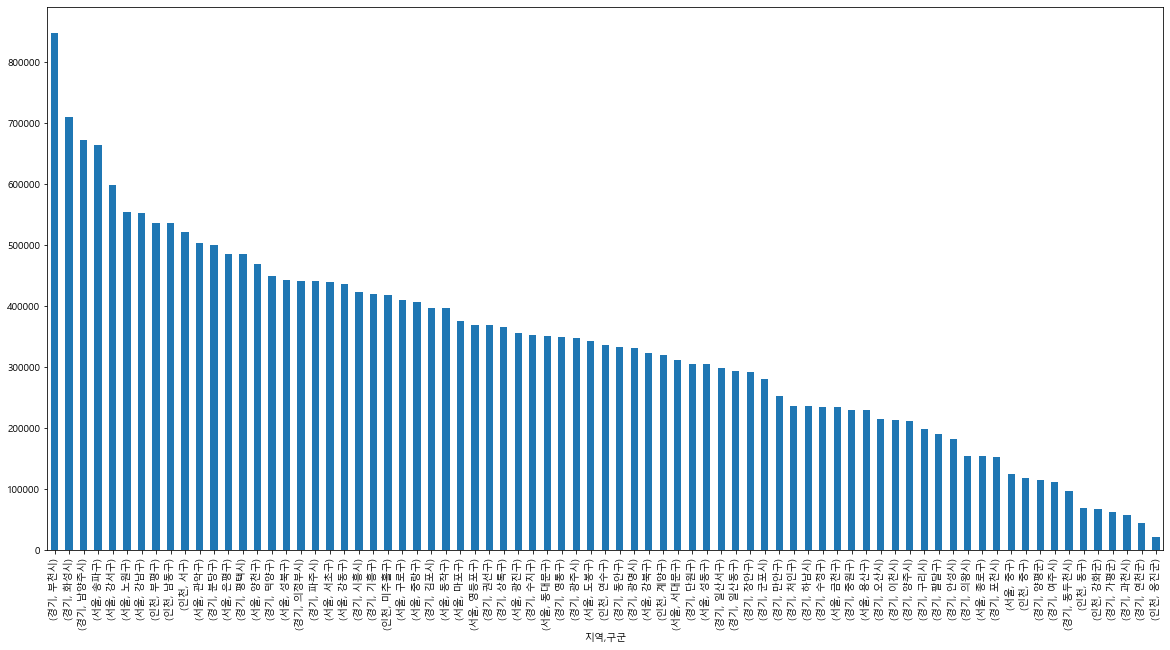

In [186]:
df.groupby(['지역','구군'])['인구'].agg('mean').sort_values(ascending=[False]).plot.bar(figsize = (20,10))

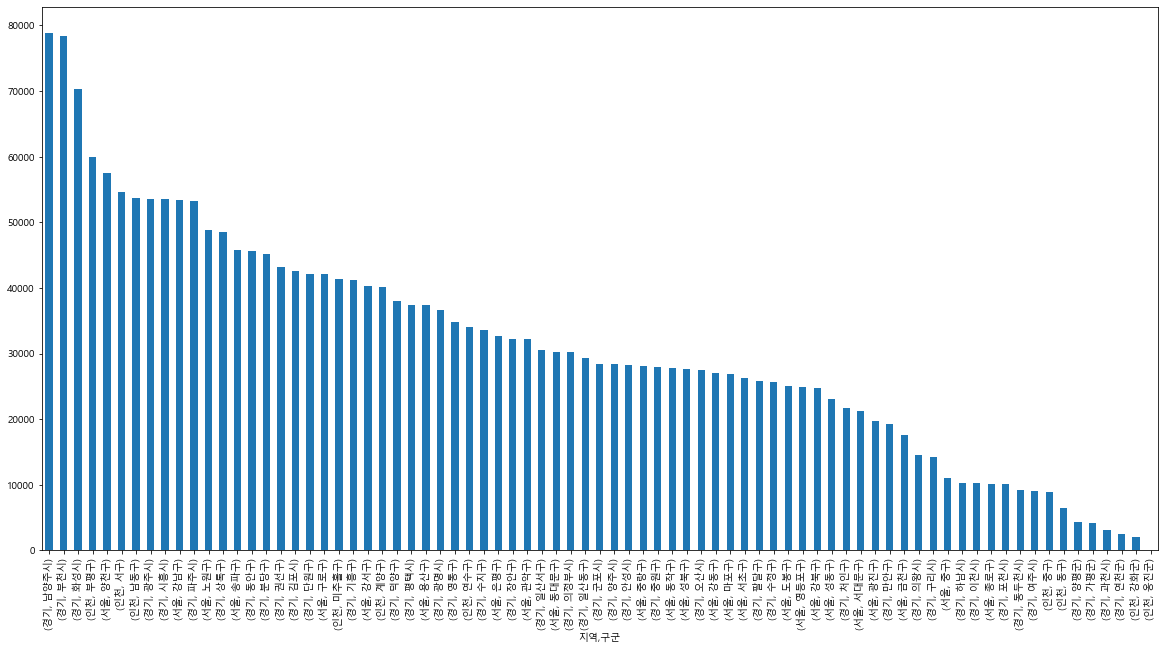

In [187]:
df.groupby(['지역','구군'])['Sales (Bag)'].agg('sum').sort_values(ascending=[False]).plot.bar(figsize = (20,10))

In [189]:
df_sale = df.groupby(['지역','구군'])['Sales (Bag)'].agg('sum').sort_values(ascending=[False])
df_pop = df.groupby(['지역','구군'])['인구'].agg('mean').sort_values(ascending=[False])

In [190]:
df_sale.to_csv("C:/jupyter_project/빅데이터_미세먼지/판매.csv", encoding='CP949')
df_pop.to_csv("C:/jupyter_project/빅데이터_미세먼지/인구.csv", encoding='CP949')

In [39]:
df_md = df.groupby(['시점','month','day']).agg('mean')
df_md = df_md.reset_index()

In [40]:
df_md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 47 columns):
시점                  792 non-null object
month               792 non-null int64
day                 792 non-null int64
UPC                 792 non-null float64
Sales (Bag)         792 non-null float64
Sales SU            792 non-null float64
박스입수                792 non-null float64
수량(CS)              792 non-null float64
금액                  792 non-null float64
가격                  792 non-null float64
인구                  792 non-null float64
선행종합지수(2015=100)    792 non-null float64
동행종합지수(2015=100)    792 non-null float64
후행종합지수(2015=100)    792 non-null float64
gdp                 792 non-null float64
연령                  792 non-null float64
평균소득                792 non-null float64
SO2                 792 non-null float64
CO                  792 non-null float64
O3                  792 non-null float64
NO2                 792 non-null float64
PM10                792 non-null float6

In [41]:
df_corr = df_md.corr()

In [42]:
df_md = df_md.rename(columns = {'Sales (Bag)' : "판매량"})

In [43]:
df_md

,시점,month,day,UPC,판매량,Sales SU,박스입수,수량(CS),금액,가격,...,중하층운량(10분위),최저운고(100m ),시정(10m),지면온도(°C),미세검색량,초미세검색량,먼지합,KF94판매량,KF80판매량,기본마스크판매량
0,2017-01,1,1,8.800000e+12,49.975610,5.036585,36.560976,2.351220,1.820849e+05,3282.585366,...,6.541667,8.966102,479.244048,-0.073214,7.000000,5.000000,119.135575,0.670732,25.073171,24.231707
1,2017-01,1,2,8.800000e+12,47.087719,11.438596,40.210526,1.784211,1.543180e+05,3304.859649,...,6.888889,8.695652,339.815476,2.565476,7.000000,5.000000,163.182824,4.228070,16.701754,26.157895
2,2017-01,1,3,8.800000e+12,47.678571,8.750000,40.035714,2.008929,1.696585e+05,3273.553571,...,0.138889,8.000000,769.369048,0.616071,7.000000,5.000000,116.107442,1.339286,21.267857,25.071429
3,2017-01,1,4,8.800000e+12,40.103448,7.724138,40.379310,1.677586,1.428412e+05,3338.344828,...,2.569444,8.888889,979.523810,1.727976,7.000000,5.000000,92.700280,1.413793,17.706897,20.982759
4,2017-01,1,5,8.800000e+12,31.625000,6.464286,39.250000,1.283929,1.136562e+05,3399.642857,...,1.444444,43.375000,1435.636905,1.049405,3.607143,0.357143,73.249095,1.196429,12.607143,17.821429
5,2017-01,1,6,8.800000e+12,27.763636,6.236364,40.218182,1.072727,9.764004e+04,3282.036364,...,3.549296,15.678571,1791.583333,3.235119,3.163636,1.563636,48.534480,1.563636,9.727273,16.472727
6,2017-01,1,7,8.800000e+12,26.505155,9.030928,44.597938,0.995876,9.370137e+04,3058.773196,...,0.521127,40.777778,777.476190,1.909259,3.123711,2.092784,104.050678,2.432990,8.505155,15.567010
7,2017-01,1,8,8.800000e+12,9.740000,2.380000,40.400000,0.392000,3.558252e+04,3402.980000,...,5.541667,26.358209,1476.511905,4.680892,3.000000,0.000000,73.672538,0.220000,3.760000,5.760000
8,2017-01,1,9,8.800000e+12,25.402299,4.183908,38.390805,1.071264,9.238720e+04,3545.149425,...,3.722222,8.441860,1014.589286,3.211875,3.000000,0.000000,105.778265,0.655172,11.505747,13.241379
9,2017-01,1,10,8.800000e+12,26.228070,5.140351,39.859649,1.036842,9.170319e+04,3372.491228,...,0.847222,9.750000,1775.059524,-1.191071,14.754386,4.736842,56.968509,0.578947,9.824561,15.824561


In [193]:
df_corr = df_total.corr()

In [194]:
df_corr.to_csv("C:/jupyter_project/빅데이터_미세먼지/검색량확인.csv", encoding='CP949')

In [18]:
df_gu_gu = df_gu_sum.drop('시점', axis =1)

In [28]:
df_gu_gu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968 entries, 0 to 1967
Data columns (total 48 columns):
지역                  1968 non-null object
구군                  1968 non-null object
UPC                 1968 non-null float64
Sales (Bag)         1968 non-null int64
Sales SU            1968 non-null float64
박스입수                1968 non-null float64
수량(CS)              1968 non-null float64
금액                  1968 non-null int64
가격                  1968 non-null float64
인구                  1968 non-null float64
선행종합지수(2015=100)    1968 non-null float64
동행종합지수(2015=100)    1968 non-null float64
후행종합지수(2015=100)    1968 non-null float64
gdp                 1968 non-null float64
연령                  1968 non-null float64
평균소득                1968 non-null float64
SO2                 1968 non-null float64
CO                  1968 non-null float64
O3                  1968 non-null float64
NO2                 1968 non-null float64
PM10                1968 non-null float64
PM25             

In [29]:

def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [30]:
cat_cols = get_cols_with_no_nans(df_gu_gu, 'no_num')

In [31]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(df_gu_gu.shape[1]))
df_gu_gu = oneHotEncode(df_gu_gu,cat_cols)
print('There are {} columns after encoding categorical features'.format(df_gu_gu.shape[1]))

There were 48 columns before encoding categorical features
There are 125 columns after encoding categorical features


In [ ]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
df_gu_gu = oneHotEncode(df_gu_gu, 구군)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

In [123]:
df_gu_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968 entries, 0 to 1967
Data columns (total 59 columns):
지역                  1968 non-null object
구군                  1968 non-null object
시점                  1968 non-null object
UPC                 1968 non-null float64
Sales (Bag)         1968 non-null int64
Sales SU            1968 non-null float64
박스입수                1968 non-null float64
수량(CS)              1968 non-null float64
금액                  1968 non-null int64
가격                  1968 non-null float64
인구                  1968 non-null float64
선행종합지수(2015=100)    1968 non-null float64
동행종합지수(2015=100)    1968 non-null float64
후행종합지수(2015=100)    1968 non-null float64
gdp                 1968 non-null float64
연령                  1968 non-null float64
평균소득                1968 non-null float64
SO2                 1968 non-null float64
CO                  1968 non-null float64
O3                  1968 non-null float64
NO2                 1968 non-null float64
PM10              

In [169]:
df_raw_x = pd.DataFrame()
df_raw_y = df_gu_sum["판매수량"]
df_raw_x = df_gu_sum[["건강_조율", "19", "65", "도시지역 인구비율 (%)","미세검색량","초미세검색량","시정(10m)","연령","평균소득"]]

In [170]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y,
                                                                test_size = 0.4, random_state=42)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (1180, 9)
train data Y size : (1180,)
test data X size : (788, 9)
test data Y size : (788,)


In [35]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = df_train_x.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16000     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 180,865
Trainable params: 180,865
Non-trainable params: 0
_________________________________________________________________


In [37]:
NN_model.fit(df_train_x, df_train_y, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 944 samples, validate on 236 samples
Epoch 1/500
944/944 [==============================] - 1s 706us/step - loss: 17912013319.4576 - mean_absolute_error: 17912013319.4576 - val_loss: 94009037.1525 - val_mean_absolute_error: 94009037.1525

Epoch 00001: val_loss improved from inf to 94009037.15254, saving model to Weights-001--94009037.15254.hdf5
Epoch 2/500
944/944 [==============================] - 0s 131us/step - loss: 3304086905.3898 - mean_absolute_error: 3304086905.3898 - val_loss: 711643753.2203 - val_mean_absolute_error: 711643753.2203

Epoch 00002: val_loss did not improve from 94009037.15254
Epoch 3/500
944/944 [==============================] - 0s 121us/step - loss: 2221947755.3898 - mean_absolute_error: 2221947755.3898 - val_loss: 2639964463.7288 - val_mean_absolute_error: 2639964463.7288

Epoch 00003: val_loss did not improve from 94009037.15254
Epoch 4/500
944/944 [==============================] - 0s 138us/step - los

In [40]:
predictions = NN_model.predict(df_test_x)

In [41]:
predictions

array([[554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.3803 ],
       [554.3803 ],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],
       [554.38025],


In [38]:
wights_file = 'Weights-478--18738.19831.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

OSError: Unable to open file (unable to open file: name = 'Weights-478--18738.19831.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [171]:
tree_final = DecisionTreeRegressor()
tree_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(tree_final.score(df_train_x,df_train_y)))
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x,df_test_y)))

Score on training set: 1.000
Score on test set: -0.626


In [172]:
rf_final = RandomForestRegressor()
rf_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(rf_final.score(df_train_x,df_train_y)))
print("score on test seg: {:.3f}".format(rf_final.score(df_test_x,df_test_y)))

Score on training set: 0.846
score on test seg: 0.085


In [173]:
gb_final = GradientBoostingRegressor()
gb_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(gb_final.score(df_train_x,df_train_y)))
print("score on test seg: {:.3f}".format(gb_final.score(df_test_x,df_test_y)))

Score on training set: 0.678
score on test seg: 0.173


In [174]:
xg_final = XGBRegressor()
xg_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(xg_final.score(df_train_x,df_train_y)))
print("score on test seg: {:.3f}".format(xg_final.score(df_test_x,df_test_y)))

NameError: name 'XGBRegressor' is not defined

In [229]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
15,습도(%),0.164
3,PM10,0.155
5,기온(°C),0.094
13,시정(10m),0.071
9,중하층운량(10분위),0.070
14,지면온도(°C),0.069
8,증기압(hPa),0.056
2,NO2,0.048
6,강수량(mm),0.048
4,PM25,0.044


Text(0, 0.5, '변수')

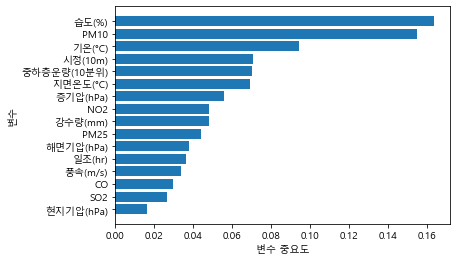

In [230]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [ ]:
estimator = RandomForestRegressor()

para_n_tree = [n_tree * 10 for n_tree in range (1,11)]
para_leaf = [n_leaf * 1 for n_leaf in range (1,21)]
para_split = [n_split * 2 for n_split in range(1, 20)]
para_depth = [depth for depth in range(1, 11)]

param_grid = {"n_estimators":para_n_tree, "max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score:\n{}".format(grid_dt.best_score_.round(3)))